In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

remove prev saved database:

In [2]:
dir_path = './data/humanModel/dataset_v0_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel/dataset_v0/', output=dir_path, ratio=(0.8, 0.2))

Copying files: 6101 files [00:00, 16909.17 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 64
IMG_SIZE = 5

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory((dir_path+'/train'),
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory((dir_path+'/val'),
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4879 images belonging to 4 classes.
Found 1222 images belonging to 4 classes.


## View some data

In [5]:
num_classes = 4

model = Sequential([
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.MaxPooling2D(),
  layers.Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  # layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 4)           112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           264       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [8]:
epochs=150
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/150


/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


77/77 [==============================] - 1s 10ms/step - loss: 1.4416 - accuracy: 0.2742 - val_loss: 1.4266 - val_accuracy: 0.2660
Epoch 2/150
77/77 [==============================] - 1s 9ms/step - loss: 1.4133 - accuracy: 0.2892 - val_loss: 1.3936 - val_accuracy: 0.3126
Epoch 3/150
77/77 [==============================] - 1s 8ms/step - loss: 1.3615 - accuracy: 0.3618 - val_loss: 1.3293 - val_accuracy: 0.3985
Epoch 4/150
77/77 [==============================] - 1s 8ms/step - loss: 1.3144 - accuracy: 0.4068 - val_loss: 1.3021 - val_accuracy: 0.4075
Epoch 5/150
77/77 [==============================] - 1s 8ms/step - loss: 1.2972 - accuracy: 0.4175 - val_loss: 1.2931 - val_accuracy: 0.4296
Epoch 6/150
77/77 [==============================] - 1s 8ms/step - loss: 1.2855 - accuracy: 0.4257 - val_loss: 1.2802 - val_accuracy: 0.4141
Epoch 7/150
77/77 [==============================] - 1s 8ms/step - loss: 1.2770 - accuracy: 0.4290 - val_loss: 1.2758 - val_accuracy: 0.4247
Epoch 8/150
77/77 [=====

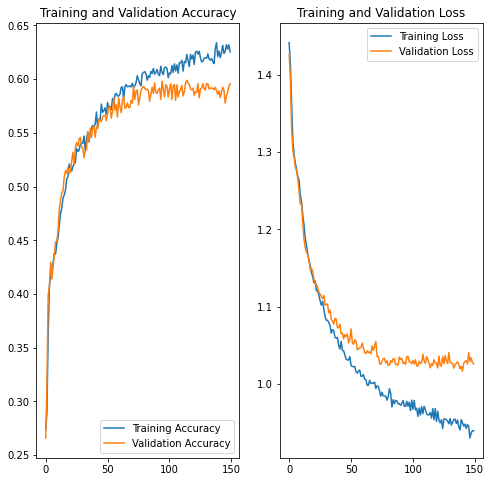

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

20/20 [==============================] - 0s 6ms/step - loss: 1.0258 - accuracy: 0.5957
Test accuracy : 0.5957446694374084


In [11]:
# Save the weights model.
model.save('./data/humanModel/model_v0.h5')

In [12]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [13]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [14]:
path = "./data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
predictions = model.predict(img_array)[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions), 100 * np.max(predictions))
)

FileNotFoundError: [Errno 2] No such file or directory: './data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png'